# Predicting Blight Violations

_This project was inspired by the final assignment of the Applied Data Science with Python Specialization from Coursera. Unlike the assignment here I use the full dataset, all features, and calculate my own target feature._

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from Blight Violation Notices (BVN), or Blight Tickets, that have been issued to property owners who have violated City of Detroit ordinances that govern how property owners must maintain the exterior of their property. Blight Tickets are issued by city inspectors, police officers, neighborhood city hall managers and other city officials who investigate complaints of blight and are managed by the Department of Administrative Hearings.

The target variable is compliance, which is __True__ if the ticket was paid early, on time, or within one month of the hearing data, __False__ if the ticket was paid after the hearing date or not at all, and __Null__ if the violator was found not responsible. Compliance is not avaliable in the dataset so it must be calculated.

The dataset for this project originates from the City of Detroit's Open Data Portal initiative and is updated daily. For this project the dataset spans tickets issued from March 2004 to March 2018. The dataset is avaliable at: https://data.detroitmi.gov/Property-Parcels/Blight-Violations/ti6p-wcg4

## Pre-Processing

Imports the raw data, calculates compliance for each ticket, removes features that cause data leakage, and seperates the data into two dataset based on when the violation occured. Violations issused before 2017 will be used to train and test the model, and tickets issued on and after 2017 will be used to validate the model.

In [1]:
# Common imports
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, hstack

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV

# To make the notebook's output stable across runs
random_seed = 12062017
np.random.seed(random_seed)

matplotlib.style.use('ggplot') 
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [3]:
def load_blight_raw(blight_path):
    '''
    Loads the raw blight_violations.csv
    Returns a pandas dataframe.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations.csv")
    blight_raw = pd.read_csv(csv_path, encoding='ISO-8859-1')
    print("RAW Blight Violations dataset has {} observations with {} features each.".format(*blight_raw.shape))
    return blight_raw

def pre_processing(blight_df):
    ''' 
    Takes blight panda dataframe and makes column names more reabable, sets ticket_id as index, creates compliance (the 
    prediction variable), and creates compliance_details (explains why a tickets was labeled as complantent or non-complantent).
    Returns a panda dataframe.
    '''
    # Makes column names more reabable
    # Gets columns from dataframe
    columns_names = pd.Series(blight_df.columns)
    # Removes parentheses, removes right spaces
    columns_names = columns_names.str.split('(').str[0].str.strip()
    # Coverts column names to lowercase and replaces spaces with underscores
    columns_names = columns_names.str.lower().str.replace(' ', '_')
    blight_df.columns = columns_names
    # Sets ticket_id as index
    blight_df.set_index('ticket_id', inplace=True)
    # Defines prediction variable compliance and helper variable compliance_detail
    # The values of these variables are NOT correct
    blight_df['compliance'] = 0
    blight_df['compliance_detail'] = np.NaN    
    return blight_df

def clean_up(blight_df):
    # Removes instances where 'ticket_issued_date' is not in (2000, 2017) 
    blight_df = blight_df[blight_df['violation_date'].str.contains('[0-9]{2}/[0-9]{2}/[20]{2}[0-9]{2}') == True]
    # Converts 'ticket_issued_date' to datetime
    blight_df.loc[:, 'violation_date'] = pd.to_datetime(blight_df['violation_date'])
    # Converts 'payment_date' to datetime
    blight_df.loc[:, 'payment_date'] = pd.to_datetime(blight_df['payment_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})')) 
    # Converts bad values in 'ticket_issued_time' to NaNs (Dataset error removed by publisher)
    #blight_df.loc[blight_df['violation_date'] == '00000000000000.000', 'violation_date'] = np.nan
    # Converts 'ticket_issued_time' to datetime.time
    blight_df.loc[:, 'ticket_issued_time'] = pd.DatetimeIndex(blight_df['ticket_issued_time']).time
    # Converts 'hearing_time' to datetime.time
    blight_df.loc[:, 'hearing_time'] = pd.DatetimeIndex(blight_df['hearing_time']).time
    # Remove "$" from 'judgement_amount'
    blight_df.loc[:, 'judgment_amount'] = blight_df['judgment_amount'].str.strip('$')    
    # Converts 'judgment_amount' to float    
    blight_df.loc[:, 'judgment_amount'] = blight_df['judgment_amount'].astype(float)
    # Removes "$" from 'payment_amount' and converts it to float
    blight_df.loc[:, 'payment_amount'] = blight_df['payment_amount'].str.strip('$').astype(float)
    # Removes "$" from 'fine_amount' and converts it to float
    blight_df.loc[:, 'fine_amount'] = blight_df['fine_amount'].str.strip('$').astype(float)
    # Removes "$" from 'admin_fee' and converts it to float
    blight_df.loc[:, 'admin_fee'] = blight_df['admin_fee'].str.strip('$').astype(float)
    # Removes "$" from 'state_fee' and converts it to float
    blight_df.loc[:, 'state_fee'] = blight_df['state_fee'].str.strip('$').astype(float)
    # Removes "$" from 'late_fee' and converts it to float
    blight_df.loc[:, 'late_fee']   = blight_df['late_fee'].str.strip('$').astype(float)
    # Removes "$" from 'discount_amount' and converts it to float
    blight_df.loc[:, 'discount_amount'] = blight_df['discount_amount'].str.strip('$').astype(float)    
    return blight_df

def null_compliance(blight_df):
    '''
    Compliance = np.NaN
    Tickets that cannot be classified as compliant or non-compliant because they were ruled as not responsible in disposition
    or they are awaiting judgement.
    Returns a pandas dataframe
    '''
    # Dispositions that are ruled as not responsible or are still pending
    null_dispositions = ['Not responsible by Dismissal', 'Not responsible by City Dismissal', 'PENDING JUDGMENT', 
                 'Not responsible by Determination','SET-ASIDE (PENDING JUDGMENT)', 'PENDING', 'Responsible by Dismissal']
    # Loops over dispositions and sets 'compliance' values to np.NaN
    # Loops over dispositions and sets 'compliance_detail' values to 'Not Responsible/Pending Judgement'
    for dispositions in null_dispositions:
        blight_df.loc[blight_df['disposition'] == dispositions, 'compliance'] = np.NaN
        blight_df.loc[blight_df['disposition'] == dispositions, 'compliance_detail'] = 'Not Responsible/Pending Judgement'
    return blight_df

def compliant(blight_df):
    '''
    Compliance = 1
    Tickets that are classified as compliant because they had no fine, fine was waved, made a payment with hearing pending,
    early payment (hearing not pending), payment on time, or payment within one month after hearing date.
    Returns a pandas dataframe
    '''
    ## Compliant by no fine
    # Fine Waived by Determintation
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'compliance'] = 1
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'compliance_detail'] = 'Compliant by no fine'
    # Fine Waived by Admission
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'compliance'] = 1
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'compliance_detail'] = 'Compliant by no fine'
    ## Compliant by Payment
    # Payment with PENDING hearing
    blight_df.loc[(
        (blight_df['hearing_date'] == 'PENDING') &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['hearing_date'] == 'PENDING') &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment with PENDING hearing'
    # Transforms values in 'hearing_date' and 'payment_date' to panda date types
    dummy_hearing_date = blight_df['hearing_date'].copy()
    blight_df.loc[blight_df['hearing_date'] == 'PENDING', 'hearing_date'] = np.nan
    blight_df.loc[:, 'hearing_date'] = pd.to_datetime(blight_df['hearing_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})'))
    # Early Payment, payment before hearing date
    blight_df.loc[(
        (blight_df['payment_date'] < blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['payment_date'] < blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by early payment'
    # Payment on time, payment on hearing date
    blight_df.loc[(
        (blight_df['payment_date'] == blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['payment_date'] == blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment on time'
    # Payment within one month after hearing date
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') <= 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') <= 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment within 1 Month'
    # Sets 'hearing_date' to orginal state
    blight_df.loc[:, 'hearing_date'] = dummy_hearing_date
    return blight_df

def non_compliant(blight_df):
    '''
    Compliance = 0
    Tickets that are classified as non-compliant because they made no payment or a payment after one month (late payment).
    Returns a pandas dataframe
    '''
    # Transforms values in 'hearing_date' to panda date types
    dummy_hearing_date = blight_df['hearing_date'].copy()
    blight_df.loc[blight_df['hearing_date'] == 'PENDING', 'hearing_date'] = np.nan
    blight_df.loc[:, 'hearing_date'] = pd.to_datetime(blight_df['hearing_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})'))
    # Non-compliant by late payment
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') > 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Non-compliant by late payment more than 1 month'
    # Non-compliant by no payment
    blight_df.loc[blight_df['compliance_detail'].isnull(), 'compliance_detail'] = 'Non-compliant by no payment'
    # Sets 'hearing_date' to orginal state
    blight_df.loc[:, 'hearing_date'] = dummy_hearing_date
    return blight_df

def populate_compliance(blight_df):
    '''
    Populates compliance and compliance_details in blight_df with the correct values. 
    Returns a panda dataframe.
    '''
    blight_df = null_compliance(blight_df)
    blight_df = compliant(blight_df)
    blight_df = non_compliant(blight_df)  
    return blight_df

def remove_leakage(blight_df):
    ''' 
    In blight_df removes variables to prevent data leakage and variables with mostly NaNs,
    Returns a panda dataframe
    '''
    blight_df = blight_df[['agency_name', 'inspector_name', 'violator_name','violation_street_number', 'violation_street_name', 
                       'mailing_address_street_name', 'mailing_address_city', 'mailing_address_state',
                        'mailing_address_zip_code', 'mailing_address_non-usa_code', 'mailing_address_country', 'violation_date', 'hearing_date', 'hearing_time', 'violation_code', 'violation_description',
                       'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 
                       'judgment_amount', 'violation_latitude', 'violation_longitude', 'compliance']]  
    return blight_df 

def process_blight(blight_path, pre_process):
    '''
    If pre_process is true - Loads the raw blight_violations.csv, cleans the data, computes compliance, removes features with 
    data leakage and saves this dataframe. If pre_process is False, then it loads the pre-processed data.
    Returns a pandas dataframe.
    '''
    if pre_process == False:
        blight_df = load_blight_raw(blight_path)
        blight_df = pre_processing(blight_df)
        blight_df = clean_up(blight_df)
        blight_df = populate_compliance(blight_df)
        blight_df = remove_leakage(blight_df)
        save_blight_data(blight_path, blight_df)
    else:
        blight_df = load_blight(blight_path)
    print("PROCESSED Blight Violations dataset has {} observations with {} features each.".format(*blight_df.shape))        
    return blight_df

def save_blight_data(blight_path, blight_df):
    '''
    Saves the processed blight_df
    Returns nothing.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations_Processed.csv")
    blight_df.to_csv(csv_path)
    
def load_blight(blight_path):
    '''
    Loads the preprocessed blight_violations.csv
    Returns a pandas dataframe.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations_Processed.csv")
    blight_df = pd.read_csv(csv_path)
    blight_df.set_index('ticket_id', inplace=True)
    return blight_df

In [4]:
# Loads the raw blight data and pre-processes
blight_df = process_blight(r"C:\Users\Adrian\Google Drive\Datasets\Blight-Violations", True)
#blight_df = process_blight(r"C:\Users\aperez\Google Drive\Datasets\Blight-Violations", False)
# Checks to make sure the data loaded properly
blight_df.info()

PROCESSED Blight Violations dataset has 373844 observations with 26 features each.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 373844 entries, 47056 to 247933
Data columns (total 26 columns):
agency_name                     373844 non-null object
inspector_name                  373844 non-null object
violator_name                   373842 non-null object
violation_street_number         373844 non-null int64
violation_street_name           373779 non-null object
mailing_address_street_name     373841 non-null object
mailing_address_city            372028 non-null object
mailing_address_state           371565 non-null object
mailing_address_zip_code        372025 non-null object
mailing_address_non-usa_code    1819 non-null object
mailing_address_country         1830 non-null object
violation_date                  373844 non-null object
hearing_date                    373234 non-null object
hearing_time                    373233 non-null object
violation_code                  37384

Now lets remove unrelevant fields and useless observations -
* Observations where compliance is _NaNs_, these observations provide no use to me
* Features that are too noisey or contain many _NaNs_: 'inspector_name', 'violator_name', 'violation_street_number', 'violation_street_name', 'mailing_address_street_name', 'mailing_address_street_name.1', and 'violation_code'.

It may look like a third of the data was removed because of missing values when those missing values could have been imputed or dealt with in a different way but almost all where removed because they were missing 'compliance' (target feature). Which cannot be inputed.

In [5]:
# Drop observations where 'compliance' is NaNs
blight_df.dropna(axis=0, subset=['compliance'], inplace=True)
# Drop observations where 'disposition' is NaNs
blight_df.dropna(axis=0, subset=['disposition'], inplace=True)
# Drop observations where 'violation_description' is NaNs
blight_df.dropna(axis=0, subset=['violation_description'], inplace=True)
# Drop observations where 'violation_longitude' is NaNs
blight_df.dropna(axis=0, subset=['violation_longitude'], inplace=True)
# Drop useless features
blight_df.drop(axis=1, columns=['inspector_name', 'violator_name', 'violation_street_number', 'violation_street_name',
       'mailing_address_street_name', 'mailing_address_zip_code', 'mailing_address_non-usa_code',
        'violation_code'], inplace=True)
blight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242642 entries, 47056 to 359077
Data columns (total 18 columns):
agency_name                242642 non-null object
mailing_address_city       241096 non-null object
mailing_address_state      240681 non-null object
mailing_address_country    1557 non-null object
violation_date             242642 non-null object
hearing_date               242642 non-null object
hearing_time               242642 non-null object
violation_description      242642 non-null object
disposition                242642 non-null object
fine_amount                242642 non-null float64
admin_fee                  242642 non-null float64
state_fee                  242642 non-null float64
late_fee                   242642 non-null float64
discount_amount            242642 non-null float64
judgment_amount            242642 non-null float64
violation_latitude         242642 non-null float64
violation_longitude        242642 non-null float64
compliance                 24

## Feature Engineering 

Now, we will construct new features. These are:
* detriot_resident - _True_ if 'mailing_address_city' is Detriot, _False_ otherwise.
* michigan_resident - _True_ if 'mailing_address_state' is Michigan, _False_ otherwise.
* us_resident - _True_ if 'mailing_address_state' is not null but _False_ if 'mailing_address_country' is not null, _False_ otherwise.
* violation_month - the numeric month (1-12) that violation occured on.
* days_difference - the number of days between when the violation occured and when the hearing date is
* hearing_weekday - name of the day of the week the hearing date is on. This features will later be categorically encoded into five features based on it values.
* disposition_clean - a cleaned version  of "disposition" that can either be: 'Fine Waived', 'Default', 'Admission', or 'Determination'. This features will later be categorically encoded into four features.
* agency_name - This features will later be categorically encoded into five features based on it values.

At the construction of each feature I will explain the reason I feel it may be useful in prediction.

### detriot_resident
_Goal_: Individuals who live in the city might be more invested in their property and care about paying their violations.

First fill "NaN" values with "unknown", then convert all the characters to lower case, and removes all punctuation. Finally use regular expressions to find all strings that start with "det".

In [6]:
# Creates 'detriot_resident' feature, setting all values to False
blight_df['detriot_resident'] = 0
# Fill all "NaN" with "unknown"
blight_df['mailing_address_city'].fillna(value="unknown", inplace=True)
# Convert all characters to lower case
blight_df.loc[:, 'mailing_address_city'] = blight_df['mailing_address_city'].str.lower()
# Removes all punctuation
blight_df.loc[:, 'mailing_address_city'] = blight_df['mailing_address_city'].str.extract('(^[a-z ]+)')
# Refill all "NaN" with "unknown"
blight_df['mailing_address_city'].fillna(value="unknown", inplace=True)
# Finds all strings that start with "det" and set "detriot_resident" to True for these values
blight_df.loc[blight_df['mailing_address_city'].str.contains('(^det)'), 'detriot_resident'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


### michigan_resident
_Goal_: Individuals who live in the state might be more invested in their property and care about paying their violations. 

First fill "NaN" values with "un", then convert all the characters to lower case, and removes all punctuation. Finally use regular expressions to find all strings that start with "mi".

In [7]:
# Creates 'michigan_resident' feature, setting all values to False
blight_df['michigan_resident'] = 0
# Fill all "NaN" with "unknown"
blight_df['mailing_address_state'].fillna(value="un", inplace=True)
# Convert all characters to lower case
blight_df.loc[:, 'mailing_address_state'] = blight_df['mailing_address_state'].str.lower()
# Removes all punctuation
blight_df.loc[:, 'mailing_address_state'] = blight_df['mailing_address_state'].str.extract('(^[a-z ]+)')
# Refill all "NaN" with "unknown"
blight_df['mailing_address_state'].fillna(value="un", inplace=True)
# Finds all strings that start with "det" and set "detriot_resident" to True for these values
blight_df.loc[blight_df['mailing_address_state'].str.contains('(^mi)'), 'michigan_resident'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


### us_resident
_Goal_: Individuals who live in the US might be more invested in their property and care about paying their violations. 

First set to True for all observations that have a known state, then False for all observations that have a non-null value in country

In [8]:
# Creates the 'us_resident' feature
blight_df['us_resident'] = 0 
# Sets 'us_resident' to True if the 'mailing_address_state' is not unknown
blight_df.loc[blight_df['mailing_address_state'] != 'un', 'us_resident'] = 1
# Sets 'us_resident' to False if the 'mailing_address_country' is not unknown
blight_df.loc[~blight_df['mailing_address_country'].isnull(), 'us_resident'] = 0

### violation_month
_Goal_: This feature will try and capture the seasonal effect of violations. (FYI - crimes trend to occur more in summer months, maybe this is also true for violations.)

Convert 'violation_date' to proper date format and extract the numeric month.

In [9]:
# Convert 'violation_date' to proper date format  
blight_df['violation_date'] = pd.DatetimeIndex(blight_df['violation_date']).date
# Extract the numeric month. Save this as 'violation_month'
blight_df['violation_month'] = pd.DatetimeIndex(blight_df['violation_date']).month

### days_difference
_Goal_: The further away a hearing is from when the violation occured, can influence if they become compliant.

Convert 'hearing_date' to proper date format and subtract 'violation_date' from 'hearing_date'. Convert this difference to days.

In [10]:
# Convert 'hearing_date' to proper date format
blight_df['hearing_date'] = pd.DatetimeIndex(blight_df['hearing_date']).date
# Subtract 'violation_date' from 'hearing_date'. Convert this difference to days.
blight_df['days_difference'] = (blight_df['hearing_date'] - blight_df['violation_date'])/np.timedelta64(1, 'D')

### hearing_weekday
_Goal_: We all hate Mondays

Gets the name of the day of the week the 'hearing_date' is on and stores this as 'hearing_weekday'. Also does 1hot encoding on this new feature to generate five features

In [11]:
# Gets the name of the day of the week the hearing date is on
blight_df['hearing_weekday'] = pd.DatetimeIndex(blight_df['hearing_date']).weekday_name
# Converts weekdays to lowercase
blight_df['hearing_weekday'] = blight_df['hearing_weekday'].str.lower()

# 1hot caterogical encoding for "disposition_clean"
blight_weekday = blight_df['hearing_weekday']
cat_encoder_weekday = CategoricalEncoder()
blight_weekday_reshaped = blight_weekday.values.reshape(-1, 1)
blight_weekday_1hot = cat_encoder_weekday.fit_transform(blight_weekday_reshaped)

# Adds new features to blight_df
blight_df = blight_df.reset_index().merge(pd.SparseDataFrame(blight_weekday_1hot, columns=list(cat_encoder_weekday.categories_[0]), index=blight_df.index).fillna(0).reset_index())
# Set 'ticket_id' as index
blight_df.set_index('ticket_id', inplace=True)

### disposition_clean

First initialize all the feature to be NaNs then populate it depending on the value of disposition. Afterwards we will perform one hot categorical encoding.

In [12]:
# Initialize all features to be NaNs
blight_df['disposition_clean'] = np.NaN
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'disposition_clean'] = 'disp_fine_waived'
blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'disposition_clean'] = 'disp_fine_waived'
blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'disposition_clean'] = 'disp_fine_waived'
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible by Default', 'disposition_clean'] = 'disp_default'
blight_df.loc[blight_df['disposition'] == 'Responsible - Compl/Adj by Default', 'disposition_clean'] = 'disp_default'
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible by Admission', 'disposition_clean'] = 'disp_admission'
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible by Determination', 'disposition_clean'] = 'disp_determination'
blight_df.loc[blight_df['disposition'] == 'Responsible - Compl/Adj by Determination', 'disposition_clean'] = 'disp_determination'
# Remove values without any 'disposition_clean' values
blight_df.dropna(axis=0, subset=['disposition_clean'], inplace=True)

# 1hot caterogical encoding for "disposition_clean"
blight_disp = blight_df['disposition_clean']
cat_encoder_disp = CategoricalEncoder()
blight_disp_reshaped = blight_disp.values.reshape(-1, 1)
blight_disp_1hot = cat_encoder_disp.fit_transform(blight_disp_reshaped)

# Adds new features to blight
blight_df = blight_df.reset_index().merge(pd.SparseDataFrame(blight_disp_1hot, columns=list(cat_encoder_disp.categories_[0]), index=blight_df.index).fillna(0).reset_index())
# Set 'ticket_id' as index
blight_df.set_index('ticket_id', inplace=True)

### agency_name
First I will convert all strings to lowercase, remove all non-letter characters and replace spaces with string. Then I will use 1hot encoding to covert each value into a binary feature

In [26]:
# Cleans up values of agency name by lowercasing all laters, removing puncation and replacing spaces with underscores
blight_df['agency_name'] = blight_df['agency_name'].str.lower().str.extract('(^[a-z ]+)')[0].str.replace(' ', '_')

# 1hot caterogical encoding for "agency_name"
blight_agency = blight_df['agency_name']
cat_encoder_ag = CategoricalEncoder()
blight_agency_reshaped = blight_agency.values.reshape(-1, 1)
blight_agency_1hot = cat_encoder_ag.fit_transform(blight_agency_reshaped)

# Adds new features to blight
blight_df = blight_df.reset_index().merge(pd.SparseDataFrame(blight_agency_1hot, columns=list(cat_encoder_ag.categories_[0]), index=blight_df.index).fillna(0).reset_index())
# Set 'ticket_id' as index
blight_df.set_index('ticket_id', inplace=True)

### violation_description
_Goal_: I will use NLP to find 10 topics that describe the violations by their description. 

FIrst, I will train a LDA model using the violations issued in 2017 and before. I will then use the top two words from each topic to describe the violation in a new feature. Afterwards, I will create 10 new binary features from this topic feature.  

NOTE: I won't be using NLP at each train-test split to prevent data leakage, because the computing time is long and will greatly increase the time in running CV or GridSearch. I am willing to sacrifice model performance on the validation data.  

In [27]:
# Use CountVectorizor to find three letter tokens, remove stop_words, remove tokens that don't appear in at least 20 documents,
# remove tokens that appear in more than 20% of the documents
vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', token_pattern='(?u)\\b\\w\\w\\w+\\b')
# Fit and transform 'violation_description' from 2017 and before
X = vect.fit_transform(blight_df.loc[blight_df['violation_date'] < datetime.date(2017, 1, 1), 'violation_description'].copy())
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word=id_map, passes=25, random_state=random_seed)
# Init an empty list for storing topics
topic_names = []
# Loops over topics
for ntopic in range(0, ldamodel.num_topics):
    # Save the first two words for each topic
    topic_names.append(ldamodel.show_topic(ntopic, 1)[0][0]+'_'+ldamodel.show_topic(ntopic, 2)[1][0])

In [28]:
model_topic_dis = ldamodel[corpus]
index_list = list(blight_df.loc[blight_df['violation_date'] < datetime.date(2017, 1, 1), :].index)
violation_topics = {}
for idx in range(0, len(index_list)):
    topic_scores = model_topic_dis[idx]
    unzip_topics = zip(*topic_scores)
    list_topics = list(unzip_topics)[1]    
    violation_topics[index_list[idx]] = topic_names[list_topics.index(max(list_topics))]

new_doc = blight_df.loc[blight_df['violation_date'] >= datetime.date(2017, 1, 1), 'violation_description']
new_doc_vect = vect.transform(new_doc)
new_doc_copus = gensim.matutils.Sparse2Corpus(new_doc_vect, documents_columns=False)
valid_topic_dis = ldamodel[new_doc_copus]
index_list = list(blight_df.loc[blight_df['violation_date'] >= datetime.date(2017, 1, 1), :].index)
for idx in range(0, len(index_list)):
    topic_scores = valid_topic_dis[idx]
    unzip_topics = zip(*topic_scores)
    list_topics = list(unzip_topics)[1]    
    violation_topics[index_list[idx]] = topic_names[list_topics.index(max(list_topics))]
    
topics_df = pd.DataFrame(list(violation_topics.items()), columns=['ticket_id', 'violation_topic'])
blight_df = blight_df.reset_index().merge(topics_df).set_index('ticket_id')    

# 1hot caterogical encoding for "agency_name"
blight_topic = blight_df['violation_topic']
cat_encoder_ag = CategoricalEncoder()
blight_topic_reshaped = blight_topic.values.reshape(-1, 1)
blight_topic_1hot = cat_encoder_ag.fit_transform(blight_topic_reshaped)

# Adds new features to blight
blight_df = blight_df.reset_index().merge(pd.SparseDataFrame(blight_topic_1hot, columns=list(cat_encoder_ag.categories_[0]), index=blight_df.index).fillna(0).reset_index())
# Set 'ticket_id' as index
blight_df.set_index('ticket_id', inplace=True)

## Visualization

I will now look for trends in the features that can help me build a better model. First I will began by removing the validation data (tickets issued on 2017 and higher).

In [29]:
# Seperate out validation data
validation_df = blight_df.loc[blight_df['violation_date'] >= datetime.date(2017, 1, 1), :].copy()
# Seperate out the model building data
model_df = blight_df.loc[blight_df['violation_date'] < datetime.date(2017, 1, 1), :].copy()

### Numerical Features

In [30]:
# Gets all the numerical features
num_features = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount', 'days_difference']
# A quick view of the descriptive statistics of the numerical features
print('Descriptive statistics of the numerical features.')
model_df[num_features].describe()

Descriptive statistics of the numerical features.


,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,days_difference
count,222228.000000,222228.000000,222228.000000,222228.000000,222228.000000,222228.000000,222228.000000
mean,335.039009,19.682498,9.926441,4.185271,1.245289,373.274239,57.930009
std,605.230117,2.476963,0.858214,20.876254,8.293816,622.110696,45.779035
min,1.000000,-60.000000,-30.000000,-1.000000,0.000000,-50.000000,-336.000000
25%,100.000000,20.000000,10.000000,0.000000,0.000000,130.000000,27.000000
50%,250.000000,20.000000,10.000000,0.000000,0.000000,280.000000,42.000000
75%,250.000000,20.000000,10.000000,0.000000,0.000000,280.000000,76.000000
max,10000.000000,20.000000,20.000000,1000.000000,1000.000000,15538.800000,2565.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001944FD6E6D8>,
      dtype=object)

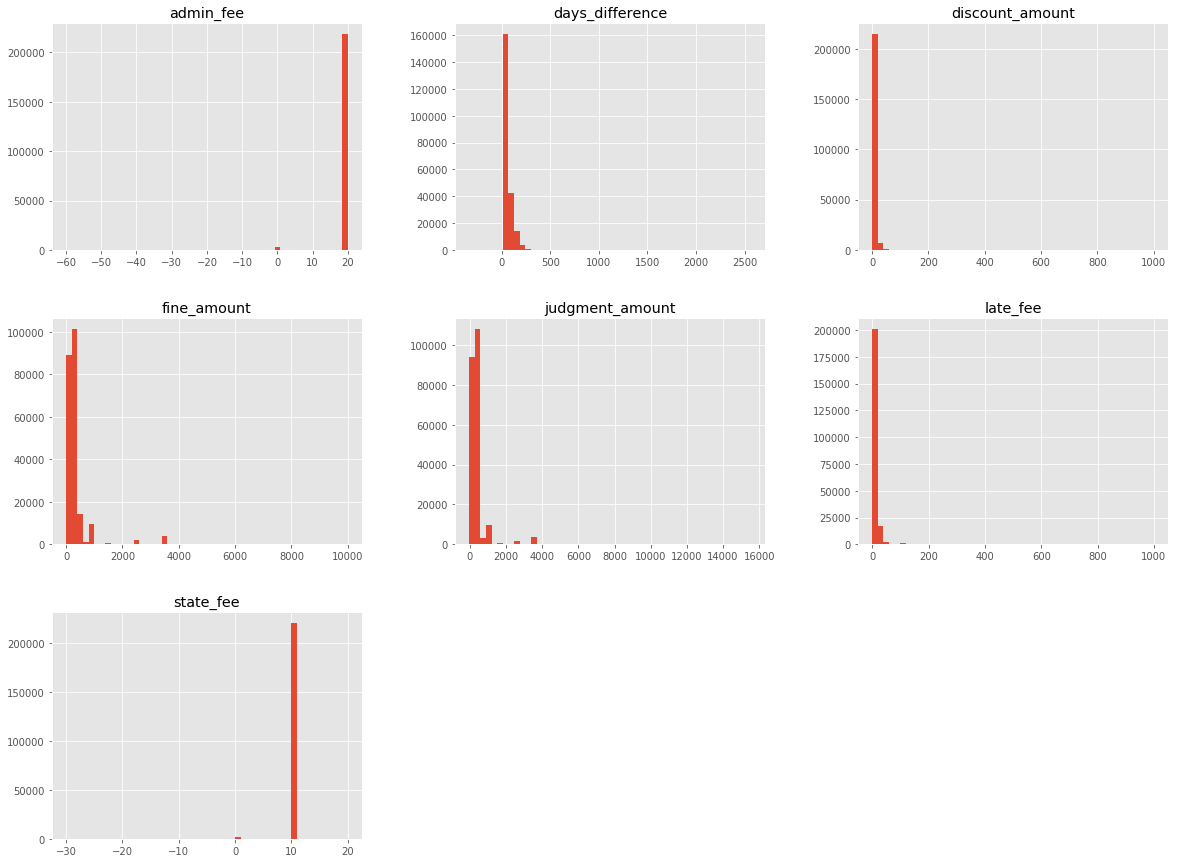

In [31]:
model_df[num_features].hist(bins=50, figsize=(20,15))

#### Admin Fee &  State Fee 
Some values in 'state_fee' and  'admin_fee' are negative. I'm going to take a closer look at these.

In [32]:
model_df.loc[model_df['state_fee'] < 0, num_features]

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,days_difference
ticket_id,,,,,,,
106587,250.0,-20.0,-10.0,25.0,0.0,245.0,41.0
94390,200.0,-17.0,-10.0,20.0,0.0,193.0,19.0
109311,250.0,-60.0,-30.0,25.0,0.0,185.0,54.0
185675,250.0,-40.0,-20.0,25.0,0.0,215.0,127.0
273121,250.0,-17.0,-10.0,25.0,0.0,248.0,77.0
174430,250.0,-20.0,-10.0,25.0,0.0,245.0,99.0
108764,500.0,-20.0,-10.0,50.0,0.0,520.0,90.0
76005,250.0,-40.0,-20.0,25.0,0.0,215.0,43.0
345259,100.0,-20.0,-10.0,10.0,0.0,80.0,64.0


In [33]:
model_df.loc[model_df['admin_fee'] < 0, num_features]

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,days_difference
ticket_id,,,,,,,
106587,250.0,-20.0,-10.0,25.0,0.0,245.0,41.0
94390,200.0,-17.0,-10.0,20.0,0.0,193.0,19.0
109311,250.0,-60.0,-30.0,25.0,0.0,185.0,54.0
185675,250.0,-40.0,-20.0,25.0,0.0,215.0,127.0
273121,250.0,-17.0,-10.0,25.0,0.0,248.0,77.0
174430,250.0,-20.0,-10.0,25.0,0.0,245.0,99.0
108764,500.0,-20.0,-10.0,50.0,0.0,520.0,90.0
76005,250.0,-40.0,-20.0,25.0,0.0,215.0,43.0
345259,100.0,-20.0,-10.0,10.0,0.0,80.0,64.0


The observations that have negative values for 'state_fee' are also the observations that have negative values for 'admin_fee', because of this and because of the small number of observations, I am going to assume that these values are correct but should be postive. I will now take the absolute value of these columns.

In [34]:
# Correct negative values in 'admin_fee' and 'state_fee
blight_df.loc[:, 'admin_fee'] = abs(blight_df['admin_fee'])
blight_df.loc[:, 'state_fee'] = abs(blight_df['state_fee'])
# Reseperate the data
# Seperate out validation data
validation_df = blight_df.loc[blight_df['violation_date'] >= datetime.date(2017, 1, 1), :].copy()
# Seperate out the model building data
model_df = blight_df.loc[blight_df['violation_date'] < datetime.date(2017, 1, 1), :].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194504DAE80>,
      dtype=object)

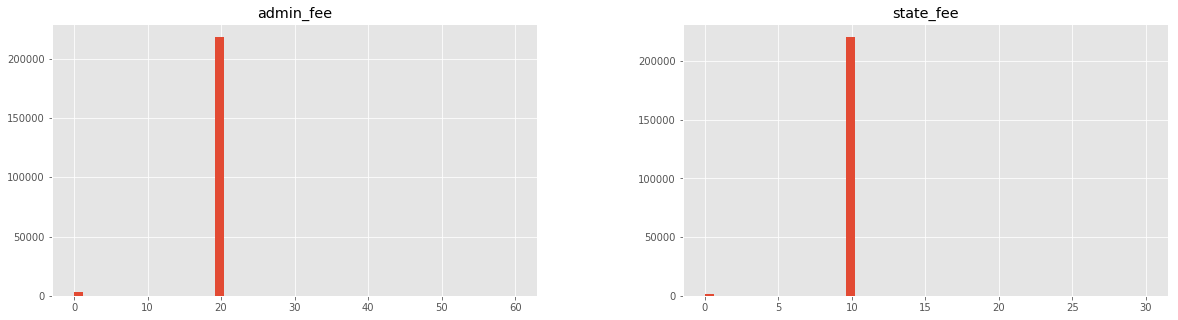

In [35]:
# Lets take another looks at those histograms
model_df[['admin_fee', 'state_fee']].hist(bins=50, figsize=(20,5))

#### Days Difference
Much better! Now I will take at look at 'days_difference', some values were negative and other are very large. First, lets look at the negative values.

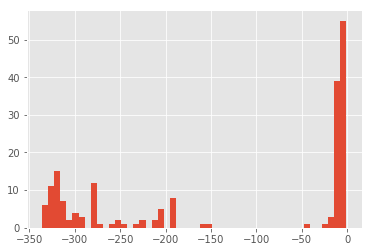

In [36]:
model_df.loc[model_df['days_difference'] < 0, 'days_difference'].hist(bins=50)

In [37]:
model_df.loc[model_df['days_difference'] < 0, ['violation_date', 'hearing_date', 'days_difference']].head()

,violation_date,hearing_date,days_difference
ticket_id,,,
353552,2016-03-19,2016-03-15,-4.0
322004,2014-10-23,2014-10-17,-6.0
239383,2010-12-08,2010-05-13,-209.0
337900,2015-08-01,2015-07-17,-15.0
102999,2006-12-28,2006-12-20,-8.0


After reviewing these values, it is hard to determine what is causing this and the best way to deal with these observations is to set them to NaN and then inpute them with the average at the model building stage.

In [38]:
# Set 'days_difference' to NaN is zero or less
blight_df.loc[blight_df['days_difference'] < 0, 'days_difference'] = np.NaN
# Seperate out validation data
validation_df = blight_df.loc[blight_df['violation_date'] >= datetime.date(2017, 1, 1), :].copy()
# Seperate out the model building data
model_df = blight_df.loc[blight_df['violation_date'] < datetime.date(2017, 1, 1), :].copy()

Now I'll see how the 'days_difference' looks.

In [39]:
model_df['days_difference'].describe()

count    222044.000000
mean         58.088564
std          45.285085
min           0.000000
25%          27.000000
50%          42.000000
75%          76.000000
max        2565.000000
Name: days_difference, dtype: float64

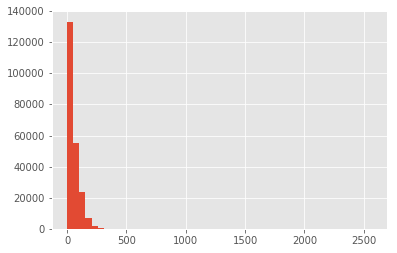

In [40]:
model_df['days_difference'].hist(bins=50)

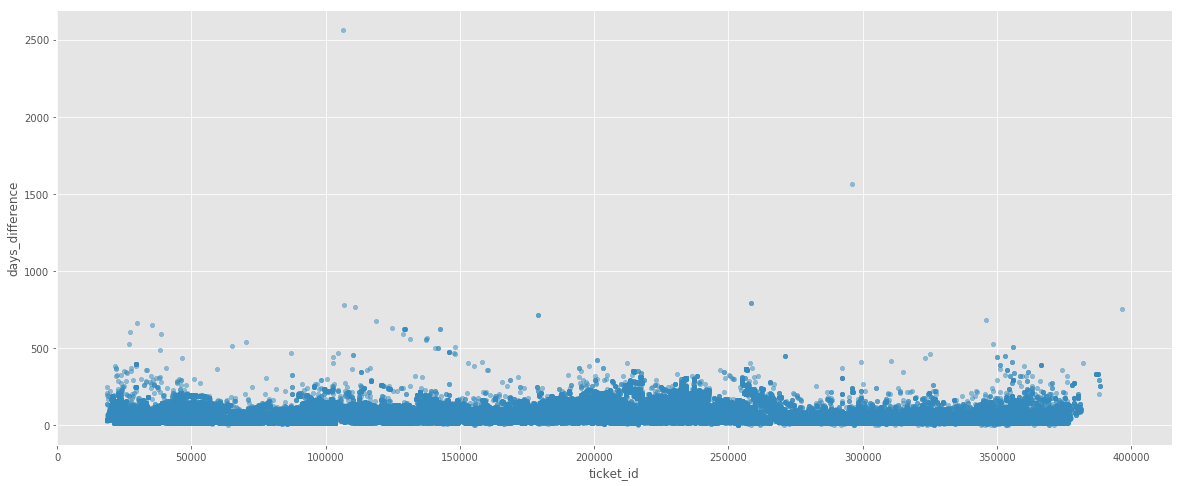

In [41]:
model_df.reset_index().plot.scatter(x='ticket_id', y='days_difference', alpha=0.5, figsize=(20,8))

Some values of 'days_difference' are very large (>1095 days). That would represent a 3 year difference between 'violation_date' and 'hearing_date'. I will label observations with a 'days_difference' over 1095 as outliers and replace them with NaNs. Like the negative values, this will inputed at the model stage.

In [42]:
# Set 'days_difference' to NaN is zero or less
blight_df.loc[blight_df['days_difference'] > 1095, 'days_difference'] = np.NaN
# Seperate out validation data
validation_df = blight_df.loc[blight_df['violation_date'] >= datetime.date(2017, 1, 1), :].copy()
# Seperate out the model building data
model_df = blight_df.loc[blight_df['violation_date'] < datetime.date(2017, 1, 1), :].copy()

I will take a (hopefully final) look at 'days_difference'.

In [43]:
model_df['days_difference'].describe()

count    222042.000000
mean         58.070487
std          44.857846
min           0.000000
25%          27.000000
50%          42.000000
75%          76.000000
max         790.000000
Name: days_difference, dtype: float64

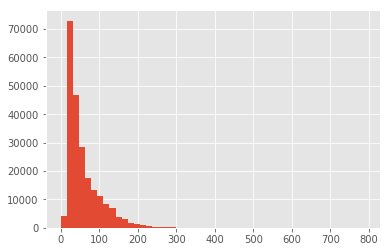

In [44]:
model_df['days_difference'].hist(bins=50)

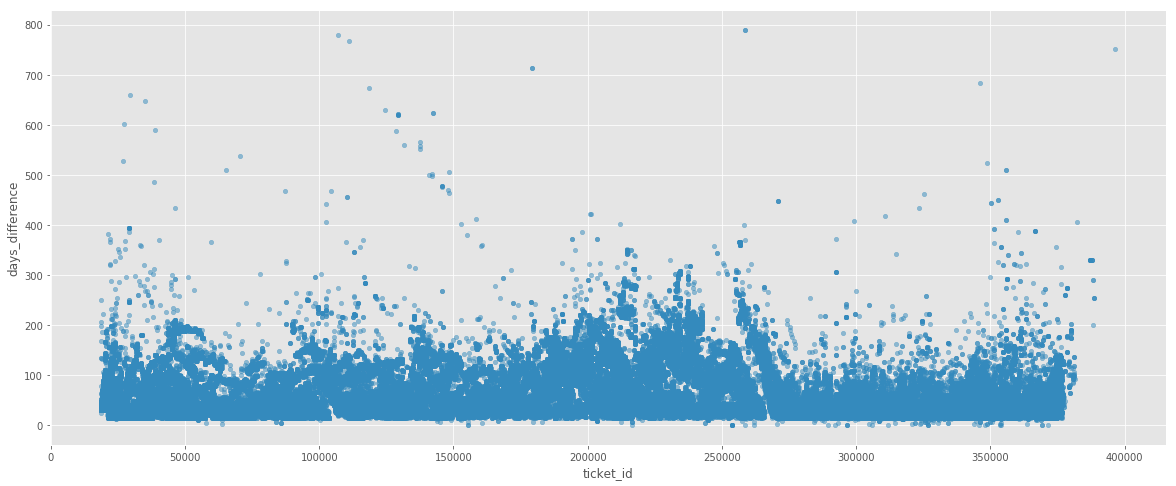

In [45]:
model_df.reset_index().plot.scatter(x='ticket_id', y='days_difference', alpha=0.5, figsize=(20,8))

Everything looks good.

#### Correlations
Now a quick look at the correlations of the numerical features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B9ECFB7F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000024BA5DDD550>]], dtype=object)

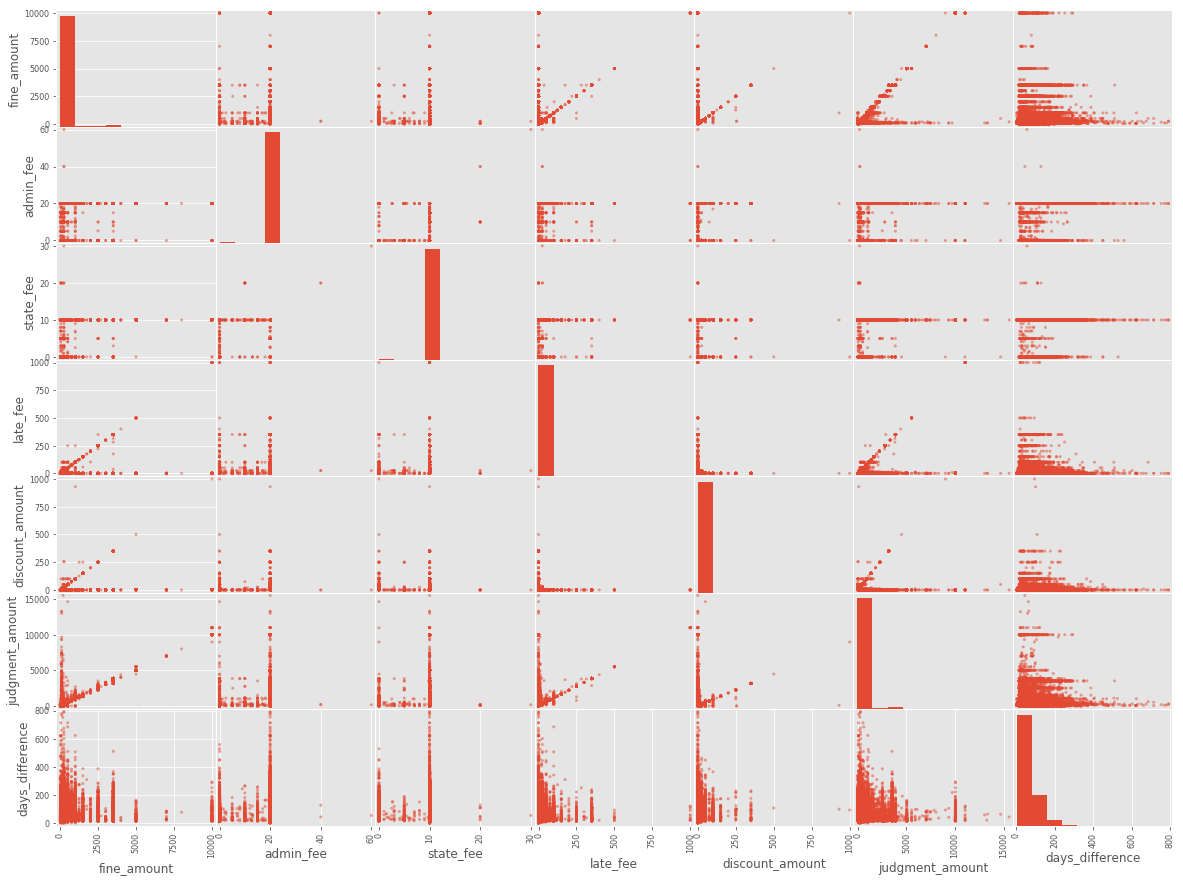

In [58]:
scatter_matrix(blight_df[num_features], figsize=(20,15))

A few of the fee features are slightly correlated with each other but it is very small and therefore will not impact model performance.

### Longitude and Latitude

I will take a detailed look at 'violation_longitude' and 'violation_latitude' and their relationship.

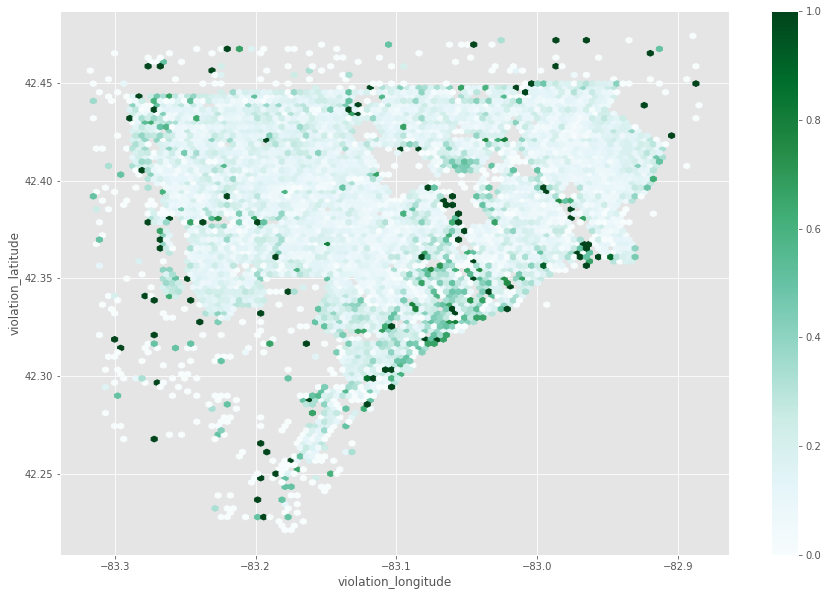

In [46]:
model_df.plot.hexbin(x='violation_longitude', y='violation_latitude', C='compliance', sharex=False,  figsize=(15,10))

The lack of clustering of dark points (or hexes) indicates that lat and long does not have a large effect on whether a violation will become compliant. 

### Categorical Features

To visually inspect these features, I will write a function that makes two stacked horizontal plots. These plots will produce a bar for each value in the categorical feature, for the first plot will let me see the number of compliant and non-compliant observations for each value. The second, and more useful, plot does the same as the first but has the percent compliant and percent non-compliant. Comparing these bars will allow me to see if that feature is going to be important in predicting. Features where they are noticable diffences in the bars means the feature is important in predicting compliance.  

In [47]:
def plot_cat_feature(model_df, feature_name):
    '''
    Plots a stacked horizontal bar graph of the categories of feature_name of the percent non-compliant and compliant.
    '''
    # groups the data by the 'feature_name'
    groups = model_df.groupby(feature_name)
    # Gets the total number of observations for each cat in 'feature_name'
    compliance_df = pd.DataFrame(groups['compliance'].size())
    # Gets the number of observations that are compliant for cat in 'feature_name'
    compliance_df['compliant'] = groups['compliance'].sum().values
    # Gets the number of observations that are non-compliant for cat in 'feature_name'
    compliance_df['non_compliant'] = compliance_df['compliance'] - compliance_df['compliant']
    # Gets the percent of observations that are compliant for cat in 'feature_name'
    compliance_df['%_compliant'] = compliance_df['compliant']/compliance_df['compliance']
    # Gets the percent of observations that are non-compliant for cat in 'feature_name'
    compliance_df['%_non_compliant'] = compliance_df['non_compliant']/compliance_df['compliance']
    # plot the results
    compliance_df[['compliant', 'non_compliant']].plot.barh(stacked=True)
    compliance_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

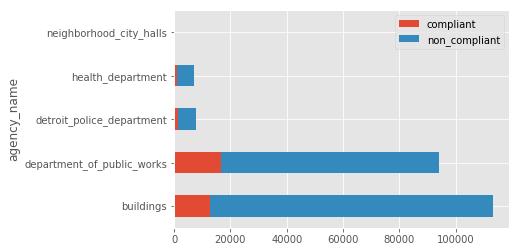

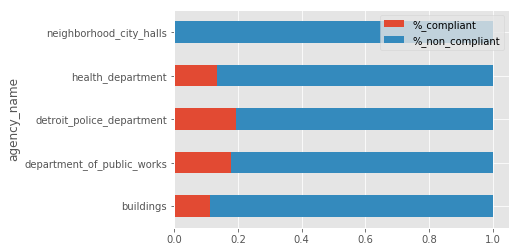

In [48]:
plot_cat_feature(model_df, 'agency_name')

This feature (which was encoded into 5 binary features) looks important because the percent compliant and non-compliant looks to depend on which agency issued the violation.

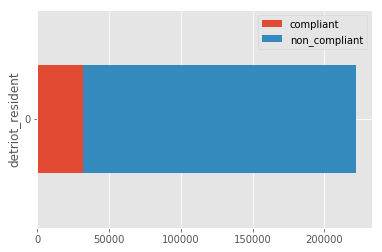

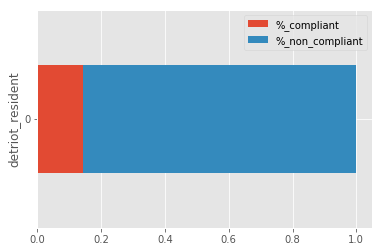

In [49]:
plot_cat_feature(model_df, 'detriot_resident')

This feature does not look important, the percent of compliant and non-compliant does not look to depend on whether the individual who received the violation resides in Detriot or not.

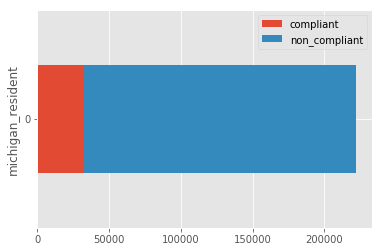

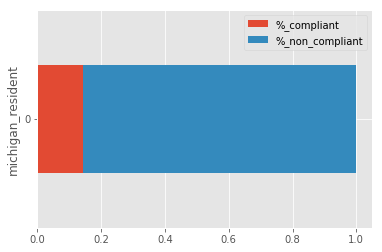

In [50]:
plot_cat_feature(model_df, 'michigan_resident')

This feature does not look important, the percent of compliant and non-compliant does not look to depend on whether the individual who received the violation resides in Michigan or not.

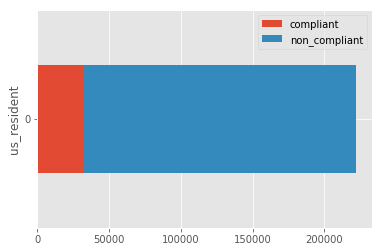

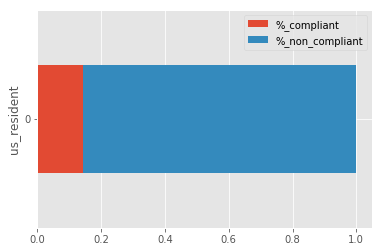

In [51]:
plot_cat_feature(model_df, 'us_resident')

This feature does not look important, the percent of compliant and non-compliant does not look to depend on whether the individual who received the violation resides in US or not.

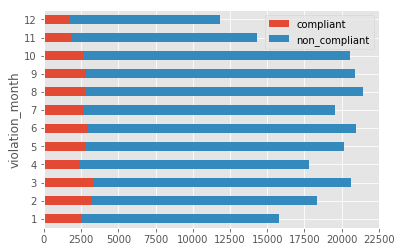

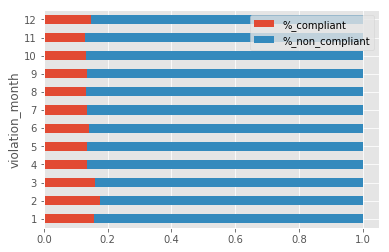

In [52]:
plot_cat_feature(model_df, 'violation_month')

This feature looks somewhat unimportant, the percent of compliant and non-compliant looks to slightly depend on what month the violation was issued on.

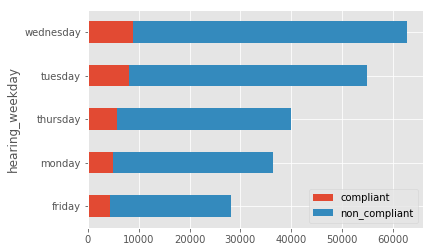

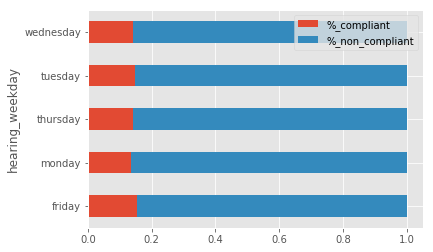

In [53]:
plot_cat_feature(model_df, 'hearing_weekday')

This feature looks important, the percent of compliant and non-compliant looks to not depend on what day the hearing date occurs on.

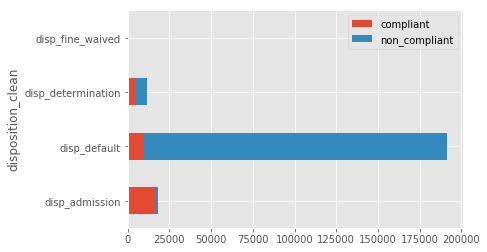

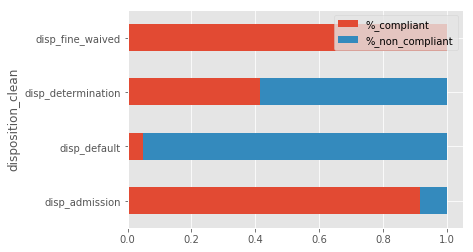

In [54]:
plot_cat_feature(model_df, 'disposition_clean')

This feature looks very important. The percent of compliant and non-compliant looks to depend very much on the ruling. 

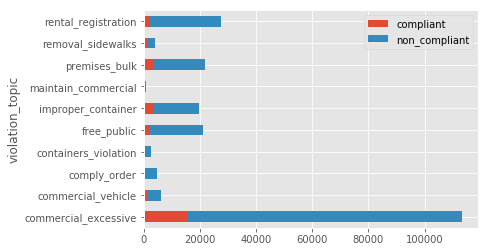

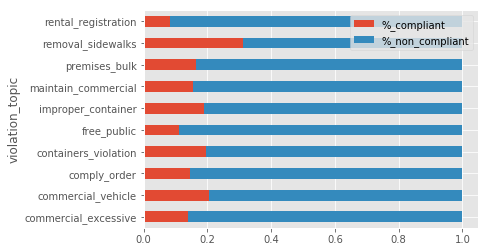

In [55]:
plot_cat_feature(model_df, 'violation_topic')

### Time Series Features

I'm going to take a quick look at 'violation_date' and 'hearing_date'. Again, I will create a function that will plot the frequency and percent of compliant and non-compliant over time.

In [56]:
def plot_time_feature(model_df, time_feature):
    '''
    Produces an area plot of (% and freq) compliant and non-compliant over time.
    '''
    # Group data by time
    groups = model_df.groupby(time_feature)
    # Calculate the total number of obs per date
    monthly_df = pd.DataFrame(groups['compliance'].size())
    # Calculate the total number of comp obs per date
    monthly_df['compliant'] = groups['compliance'].sum().values
    # Calculate the total number of non-comp obs per date
    monthly_df['non_compliant'] = monthly_df['compliance'] - monthly_df['compliant']
    # Calculate the % of comp obs per date
    monthly_df['%_compliant'] = monthly_df['compliant']/monthly_df['compliance']
    # Calculate the % of non-comp obs per date
    monthly_df['%_non_compliant'] = monthly_df['non_compliant']/monthly_df['compliance']  
    # Plot area plot for freq
    monthly_df[['compliant', 'non_compliant']].plot.area(figsize=(15,5))
    # Plot area plot for %
    monthly_df[['%_compliant', '%_non_compliant']].plot.area(figsize=(15,5))   

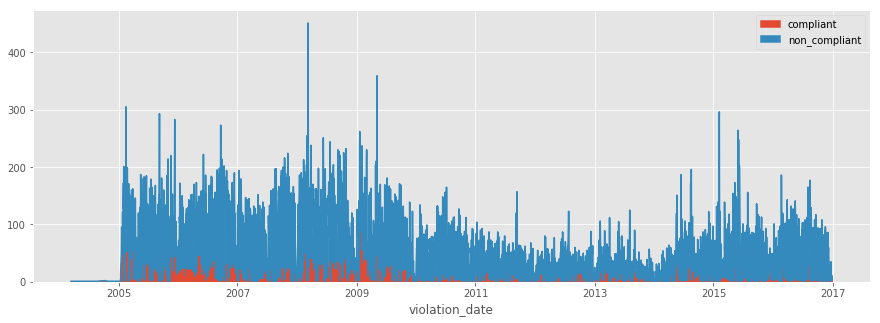

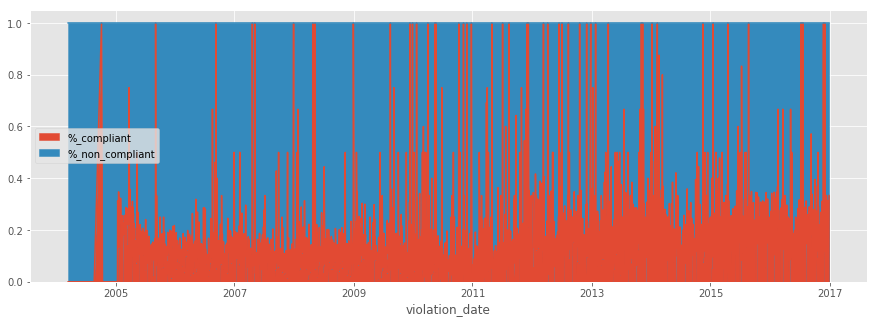

In [57]:
plot_time_feature(model_df, 'violation_date')

Looking at the top plot, I see a lot of noise and no signal. The bottom plot doesn't add anything new either. Both plots are more visually interesting than useful.

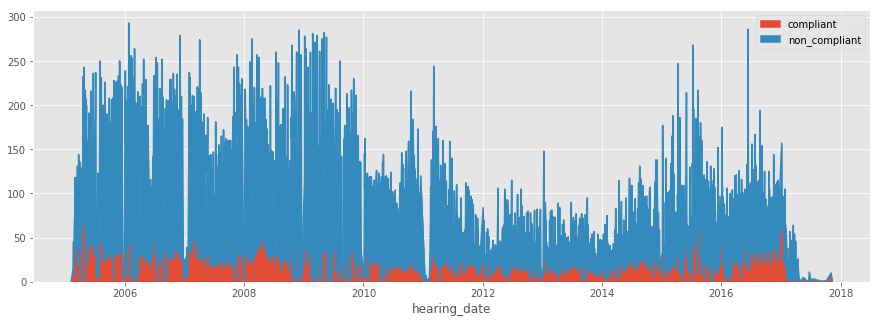

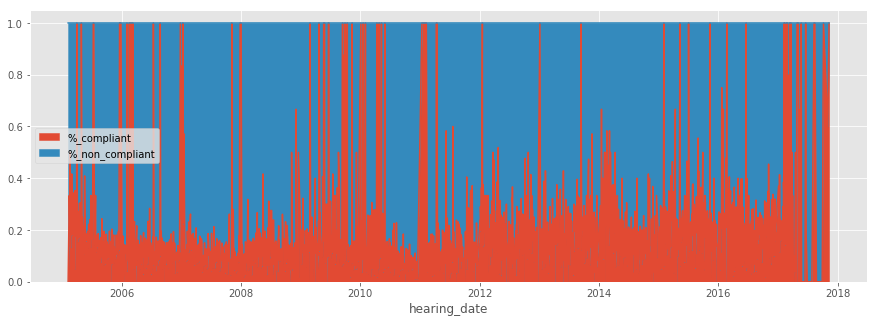

In [58]:
plot_time_feature(model_df, 'hearing_date')

Same as the 'violation_date' plots.

## Correlations
Looking at the correlation between the features and the target 'compliance' will give me an idea of what features are more important in the model's prediction power.

In [59]:
# Get the correlation matrx
corr_matrix = model_df.corr()
# Computes the correlations based on 'compliance'
corr_matrix["compliance"].sort_values(ascending=False)

compliance                    1.000000
disp_admission                0.660588
discount_amount               0.341075
disp_determination            0.184828
disp_fine_waived              0.163016
department_of_public_works    0.085044
removal_sidewalks             0.067525
improper_container            0.042065
commercial_vehicle            0.029783
detroit_police_department     0.028355
premises_bulk                 0.019940
containers_violation          0.016094
late_fee                      0.012836
friday                        0.010133
tuesday                       0.007979
maintain_commercial           0.002199
comply_order                  0.000419
neighborhood_city_halls      -0.000867
thursday                     -0.002320
days_difference              -0.004046
admin_fee                    -0.005018
health_department            -0.005146
wednesday                    -0.005190
commercial_excessive         -0.008963
monday                       -0.009691
violation_longitude      

Features with great correlation (>|0.50|) are: 'disp_default',  'disp_admission'            

In [14]:
# Save the final dataset
blight_df.to_csv(r"C:\Users\Adrian\Google Drive\Datasets\Blight-Violations\Blight-Violations-FINAL.csv")

NameError: name 'blight_df' is not defined

## Model Selection

In [16]:
useless_cols = ['agency_name', 'violation_date', 'hearing_date', 'hearing_weekday', 'disposition_clean', 'violation_topic', 
                "mailing_address_city", "mailing_address_state", "mailing_address_country", "hearing_time",
                "violation_description", "disposition"]
blight_df = pd.read_csv(r"C:\Users\Adrian\Google Drive\Datasets\Blight-Violations\Blight-Violations-FINAL.csv")
blight_df.drop(useless_cols, axis=1, inplace = True)

## H2O AutoML

In [5]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\ProgramData\Anaconda3\h2o_jar\h2o.jar
  Ice root: C:\Users\Adrian\AppData\Local\Temp\tmp01wxy3hp
  JVM stdout: C:\Users\Adrian\AppData\Local\Temp\tmp01wxy3hp\h2o_Adrian_started_from_python.out
  JVM stderr: C:\Users\Adrian\AppData\Local\Temp\tmp01wxy3hp\h2o_Adrian_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,6 months and 16 days !!!
H2O cluster name:,H2O_from_python_Adrian_wgqqc5
H2O cluster total nodes:,1
H2O cluster free memory:,3.526 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [21]:
h2o_df = h2o.H2OFrame.from_python(blight_df.drop("ticket_id", axis = 1))
h2o_df.describe()

C:\ProgramData\Anaconda3\lib\site-packages\h2o\utils\shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:242641
Cols:38




,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,violation_latitude,violation_longitude,compliance,detriot_resident,michigan_resident,us_resident,violation_month,days_difference,friday,monday,thursday,tuesday,wednesday,disp_admission,disp_default,disp_determination,disp_fine_waived,buildings,department_of_public_works,detroit_police_department,health_department,neighborhood_city_halls,commercial_excessive,commercial_vehicle,comply_order,containers_violation,free_public,improper_container,maintain_commercial,premises_bulk,removal_sidewalks,rental_registration
type,int,real,real,real,real,real,real,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,1.0,0.0,0.0,-1.0,0.0,-50.0,42.221238634,-83.317266112,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,335.4637344884009,19.678377520699332,9.919688428583799,4.14207532939612,1.3545752778796658,374.4848168281541,42.39066544743836,-83.11289434334861,0.14871353151363537,0.0,0.0,0.0,6.31195057719017,60.27569879523036,0.13435486995190427,0.16077662060410236,0.17631397826418455,0.2414183917804493,0.28713613939935956,0.08349784249158221,0.8568955782411052,0.05425711235941164,0.005349466907900973,0.5048775763370577,0.430232318528196,0.035612283167313026,0.02927370065240417,4.121315029199517e-06,0.5012425764813037,0.030180389958828064,0.019992499206646856,0.011939449639591001,0.0888143388792496,0.09246170268009116,0.004100708454053519,0.11368235376543948,0.017713411995499525,0.11987256893929715
maxs,10000.0,60.0,30.0,1000.0,1000.0,15538.8,42.4740029960001,-82.885327691,1.0,0.0,0.0,0.0,12.0,790.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,591.804591066427,2.483897349354383,0.8892347240832056,20.50755287051191,8.854522563570564,609.9109101277996,0.037226559229024424,0.09545858583887355,0.3558066031006377,0.0,0.0,0.0,3.23603280713384,46.01488181140194,0.34103389596640016,0.3673255435608142,0.38108786108062614,0.4279442798461078,0.45242659121831513,0.2766338160451327,0.3501800274323718,0.2265248101133421,0.07294430780185768,0.4999772389659656,0.4951095645353136,0.1853218551551612,0.16857303526182255,0.002030102221367071,0.4999994863300646,0.17108376501067757,0.13997456887074025,0.10861375511800032,0.28447616000828096,0.28967720319177953,0.06390547296832934,0.31742572590725365,0.13190799346779392,0.3248131323832878
zeros,0,3696,1877,207813,227266,145,0,0,206557,242641,242641,242641,0,22,210041,203630,199860,184063,172970,222381,34723,229476,241343,120137,138249,234000,235538,242640,121019,235318,237790,239744,221091,220206,241646,215057,238343,213555
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,188,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,200.0,20.0,10.0,0.0,0.0,230.0,42.354203586,-83.079859475,0.0,0.0,0.0,0.0,8.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,100.0,20.0,10.0,0.0,0.0,130.0,42.3807217840001,-83.2518317729999,0.0,0.0,0.0,0.0,4.0,15.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,200.0,20.0,10.0,0.0,0.0,230.0,42.445731999,-83.079310676,0.0,0.0,0.0,0.0,2.0,86.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
y = "compliance"
X = h2o_df.columns
X.remove(y)

In [30]:
h2o_df.asfactor

TypeError: asfactor() takes 1 positional argument but 2 were given

In [24]:
aml = H2OAutoML(max_models = 10, seed = random_seed)
aml.train(x = x, y = y, training_frame = h2o_df)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
lb = aml.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mae,rmsle
StackedEnsemble_AllModels_0_AutoML_20180924_210632,0.045966,0.214397,0.092451,0.150043
StackedEnsemble_BestOfFamily_0_AutoML_20180924_210632,0.046006,0.21449,0.092454,0.150067
GBM_grid_0_AutoML_20180924_210632_model_3,0.04661,0.215893,0.094487,0.150991
XRT_0_AutoML_20180924_210632,0.046691,0.216082,0.092341,0.151538
DRF_0_AutoML_20180924_210632,0.046823,0.216386,0.092635,0.151853
GBM_grid_0_AutoML_20180924_210632_model_2,0.04697,0.216727,0.095514,0.151589
GBM_grid_0_AutoML_20180924_210632_model_4,0.047009,0.216815,0.096142,0.151817
GBM_grid_0_AutoML_20180924_210632_model_1,0.047288,0.217459,0.096337,0.152108
GBM_grid_0_AutoML_20180924_210632_model_0,0.047489,0.217921,0.096883,0.152453
DeepLearning_0_AutoML_20180924_210632,0.055968,0.236575,0.096678,nan


### WORK NEEDED

Build pipeline to inpute missing values and standized the numerical features

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [118]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import ExtraTreesClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
forest = ExtraTreesClassifier(n_estimators = 250, random_state = random_seed, n_jobs = -1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [151]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    if importances[indices[f]] > 0.01:
        print("{}. {} - {:.4}".format(f + 1, X_train.columns[indices[f]], importances[indices[f]]))
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. disp_default - 0.2498
2. disp_admission - 0.2096
3. violation_latitude - 0.1082
4. violation_longitude - 0.1079
5. days_difference - 0.08381
6. violation_month - 0.04747
7. late_fee - 0.04728
8. disp_determination - 0.03113
9. discount_amount - 0.02387
10. judgment_amount - 0.02163
11. disp_fine_waived - 0.01246


In [165]:
important_features = list(X_train.columns[forest.feature_importances_ > 0.01])

In [169]:
pipe = Pipeline([
    ('standardize', StandardScaler())
])

In [172]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 5, 10, 15, 20, 25, 30],
              "max_depth": [1, 5, 10, 15, 20, 25, 30],
              "min_samples_leaf": [1, 5, 10, 15, 20, 25, 30],
              "max_leaf_nodes": [None, 5, 10, 15, 20, 25, 30],
              }

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs = -1, scoring = 'roc_auc')
clf.fit(X[important_features], y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.9313060140579635 {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_leaf': 10, 'min_samples_split': 2}
